# Wrench Whisperer: Predicting Machine Breakdowns Before They Happen"?

In [17]:
# Importing the Libraries

import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statistics
from sklearn.model_selection import train_test_split
import category_encoders as ce
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

# Set display options for pandas
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 10)

In [22]:
# Loading the data

df = pd.read_csv(r"D:\1 Vicky\Data Science - Study materials & Practice programs - Online\Machine Learning\Datasets\Project\Predictive Maintenance\predictive_maintenance.csv")
df.sample(6)

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
6268,6269,L53448,L,300.9,310.5,1616,33.5,25,0,No Failure
3298,3299,L50478,L,301.2,310.3,1499,38.1,61,0,No Failure
9312,9313,H38726,H,298.5,309.4,1573,33.6,143,0,No Failure
2193,2194,M17053,M,299.5,308.9,1448,42.9,74,0,No Failure
9511,9512,L56691,L,299.1,310.3,1449,40.7,40,0,No Failure
2492,2493,H31906,H,299.0,308.8,1382,58.5,199,0,No Failure


### 1. Data Exploration

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


In [24]:
print('The number of duplicated values:', df.duplicated().sum())

The number of duplicated values: 0


In [25]:
df.describe()

,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900
std,2886.89568,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981
min,1.00000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000
25%,2500.75000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000
50%,5000.50000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000
75%,7500.25000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000
max,10000.00000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000


### 2. Data Cleaning

In [ ]:
# Dropping unnecessary columns

df = df.drop(["UDI", "Product ID"], axis=1)

In [28]:
# Converting temperatures from Kelvin to Celsius

df["Air temperature [K]"] = df["Air temperature [K]"] - 272.15
df["Process temperature [K]"] = df["Process temperature [K]"] - 272.15

In [29]:
# Renaming columns for clarity

df.rename(columns={"Air temperature [K]": "Air temperature [°C]", "Process temperature [K]": "Process temperature [°C]"}, inplace=True)

In [30]:
# Creates a new feature representing the difference between process and air temperature

df["Temperature difference [°C]"] = df["Process temperature [°C]"] - df["Air temperature [°C]"]

In [31]:
df.sample(5)

,Type,Air temperature [°C],Process temperature [°C],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type,Temperature difference [°C]
1143,L,24.85,35.75,1479,39.2,151,0,No Failure,10.9
5540,L,30.25,39.65,1493,38.4,132,0,No Failure,9.4
668,L,25.35,36.75,1738,24.0,195,0,No Failure,11.4
9220,L,25.65,36.75,1282,58.1,108,0,No Failure,11.1
5866,L,29.35,38.95,1459,45.1,97,0,No Failure,9.6


### 3. Data Visualization

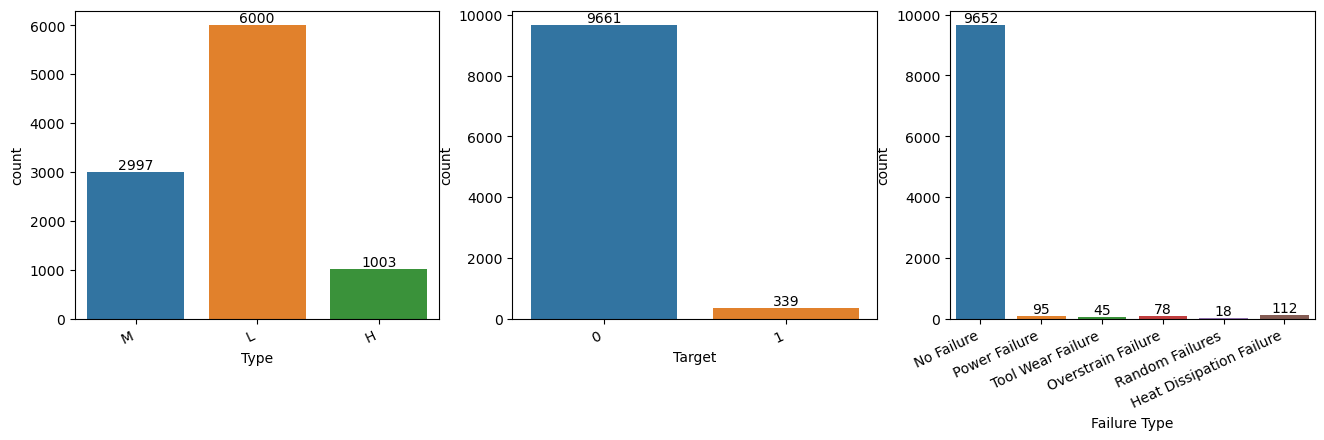

In [32]:
ax = plt.figure(figsize=(16, 4))
for idx, feature in enumerate(['Type', 'Target', 'Failure Type']):
    ax = plt.subplot(1, 3, 1+idx)
    ax = sns.countplot(x=feature, data=df)
    ax.bar_label(ax.containers[0])
    plt.xticks(rotation=25, ha='right')

In [33]:
# Filtering: Removes rows where certain conditions are met (e.g., No Failure with Target 1) to balance the dataset.

df_ = df[(df['Failure Type'] == 'No Failure') & (df['Target'] == 1)]
df_merged = df.merge(df_, indicator=True, how='outer')
df = df_merged[df_merged['_merge'] == 'left_only'].drop('_merge', axis=1)

In [34]:
# Resetting the DataFrame index after row removal

df.reset_index(drop=True, inplace=True)

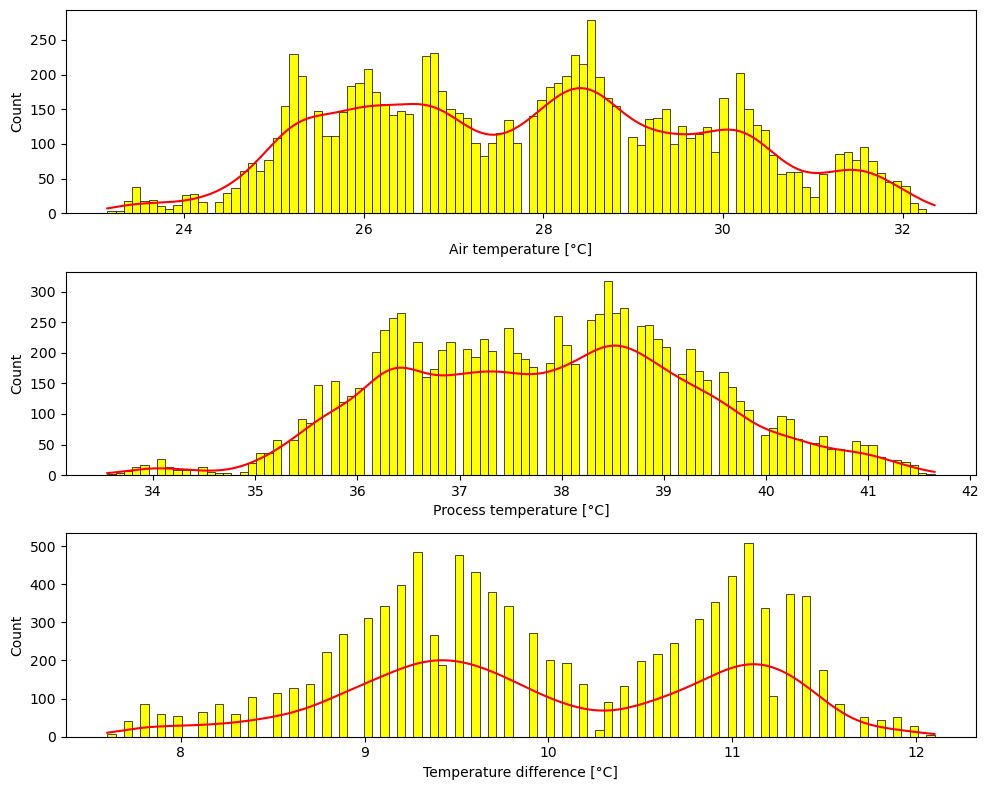

In [37]:
# Creating a subplot with multiple axes

figure, axes = plt.subplots(3, 1, figsize=(10, 8))

# Plotting histograms of features with KDE (Kernel Density Estimate)

for idx, col in enumerate(["Air temperature [°C]", "Process temperature [°C]", "Temperature difference [°C]"]):
    sns.histplot(data=df, x=col, kde=True, bins=100, color="red", facecolor="yellow", ax=axes[idx])
plt.tight_layout()
plt.show()

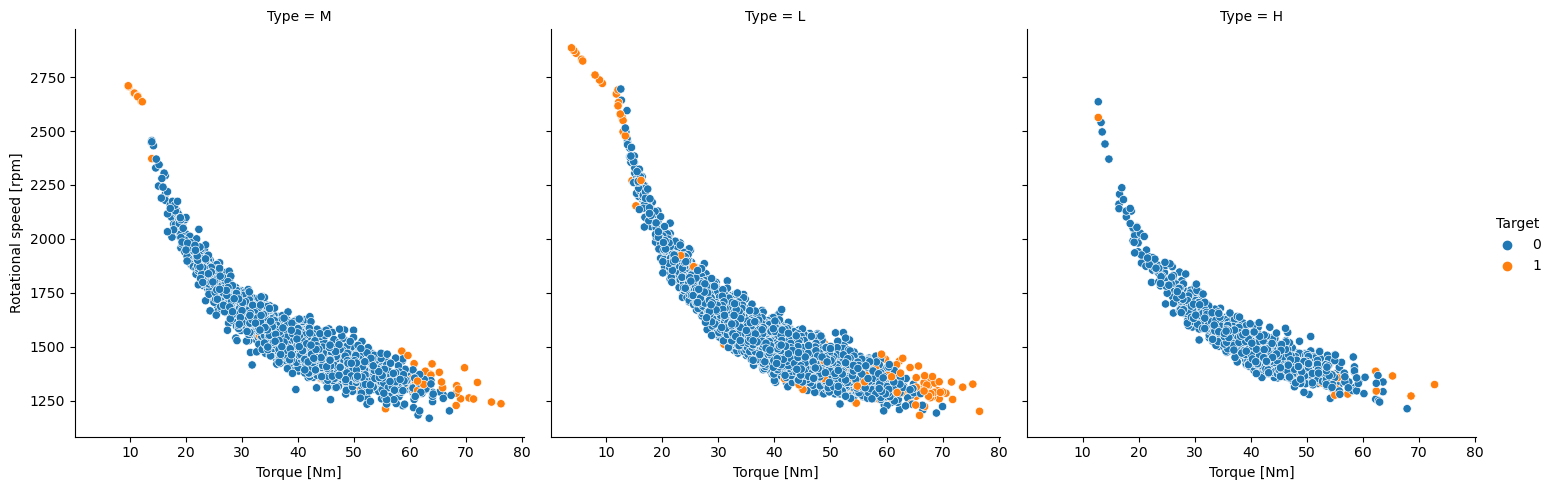

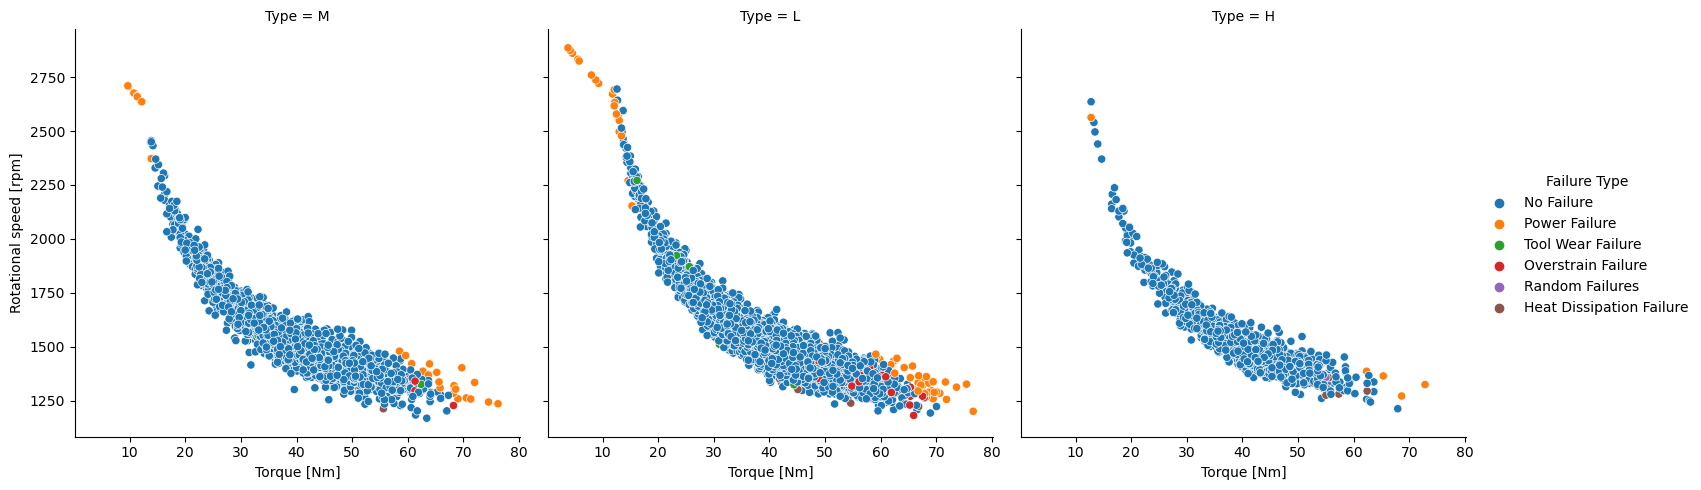

In [38]:
# Plotting scatter plots showing relationships between Torque [Nm] and Rotational speed [rpm] with hue parameter for target categories

for hue_param in ['Target', 'Failure Type']:
    sns.relplot(data=df, x="Torque [Nm]", y="Rotational speed [rpm]", hue=hue_param, col="Type", palette='tab10')
    plt.show()

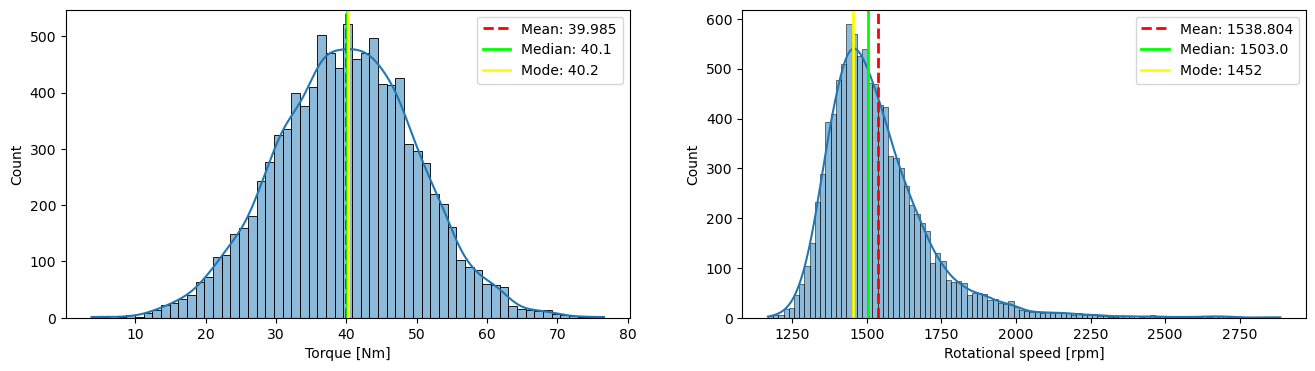

In [39]:
# Plotting histograms for Torque [Nm] and Rotational speed [rpm] with mean, median, and mode lines

fig, ax = plt.subplots(1, 2, figsize=(16, 4))
for idx, feature in enumerate(['Torque [Nm]', 'Rotational speed [rpm]']):
    sns.histplot(data=df[feature], kde=True, ax=ax[0+idx])
    ax[0+idx].axvline(x=df[feature].mean(), color='red', linestyle='--', linewidth=2, label='Mean: {}'.format(round(df[feature].mean(), 3)))
    ax[0+idx].axvline(x=df[feature].median(), color='lime', linewidth=2, label='Median: {}'.format(round(df[feature].median(), 3)))
    ax[0+idx].axvline(x=statistics.mode(df[feature]), color='yellow', linewidth=2, label='Mode: {}'.format(statistics.mode(df[feature])))
    ax[0+idx].legend()
plt.show()

### 4. Feature Selection

In [40]:
# Encoding categorical features into ordinal integers

encoder = ce.OrdinalEncoder(cols=['Type', 'Failure Type'])
df = encoder.fit_transform(df)

# Encoding Failure Type for modeling

scaler = LabelEncoder()
df['Failure Type'] = scaler.fit_transform(df['Failure Type'])
df.head()

,Type,Air temperature [°C],Process temperature [°C],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type,Temperature difference [°C]
0,1,25.95,36.45,1551,42.8,0,0,0,10.5
1,2,26.05,36.55,1408,46.3,3,0,0,10.5
2,2,25.95,36.35,1498,49.4,5,0,0,10.4
3,2,26.05,36.45,1433,39.5,7,0,0,10.4
4,2,26.05,36.55,1408,40.0,9,0,0,10.5


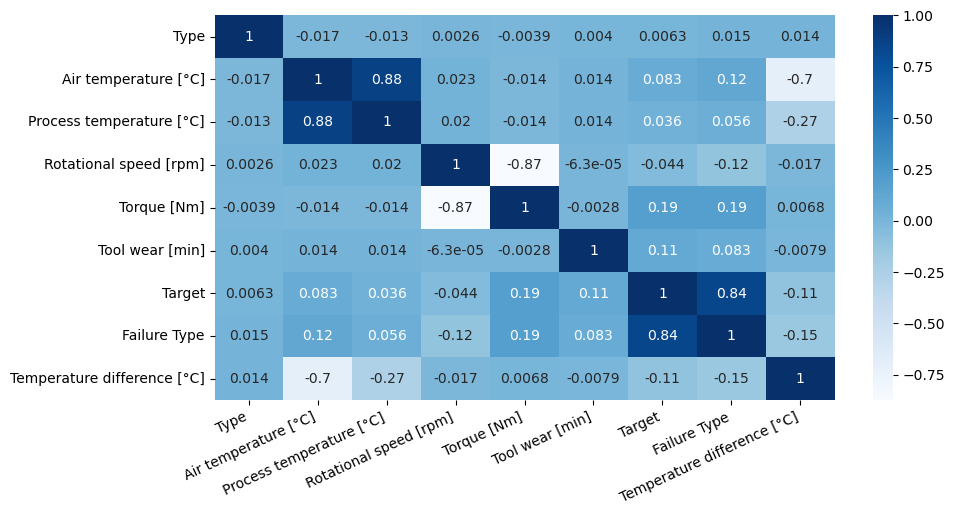

In [41]:
# Plotting a heatmap of feature correlations

plt.figure(figsize=(10, 5))
sns.heatmap(df.corr(), annot=True, cmap="Blues")
plt.xticks(rotation=25, ha="right")
plt.show()

In [42]:
# Train-Test Split - Splitting data into training and testing sets

X = df.drop(columns="Failure Type", axis=1)
y = df["Failure Type"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)
print('The train classes:', y_train.value_counts())
print()
print('The test classes:', y_test.value_counts())

The train classes: 0    7710
5      83
1      80
3      67
2      35
4      17
Name: Failure Type, dtype: int64

The test classes: 0    1933
5      29
1      15
3      11
2      10
4       1
Name: Failure Type, dtype: int64


### 5. Modelling

In [43]:
# Model Evaluation Function

def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    train_acc = round(model.score(X_train, y_train) * 100, 2)
    test_acc = round(accuracy_score(y_pred, y_test) * 100, 2)
    precision = round(precision_score(y_test, y_pred, average='weighted') * 100, 2)
    recall = round(recall_score(y_test, y_pred, average='weighted') * 100, 2)
    f1 = round(f1_score(y_test, y_pred, average='weighted') * 100, 2)
    
    print(f"Training Accuracy: {train_acc}%")
    print(f"Test Accuracy: {test_acc}%")
    print(f"Precision: {precision}%")
    print(f"Recall: {recall}%")
    print(f"F1 Score: {f1}%")
    print("\033[1m--------------------------------------------------------\033[0m")
    print("Classification Report: \n", classification_report(y_test, y_pred))
    print("\033[1m--------------------------------------------------------\033[0m")
    
    # Plotting the Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title('Confusion Matrix')
    plt.show()

Evaluating Logistic Regression...
Training Accuracy: 96.61%
Test Accuracy: 96.7%
Precision: 94.83%
Recall: 96.7%
F1 Score: 95.44%
--------------------------------------------------------
Classification Report: 
               precision    recall  f1-score   support

           0       0.97      1.00      0.98      1933
           1       1.00      0.07      0.12        15
           2       0.00      0.00      0.00        10
           3       0.20      0.18      0.19        11
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00        29

    accuracy                           0.97      1999
   macro avg       0.36      0.21      0.22      1999
weighted avg       0.95      0.97      0.95      1999

--------------------------------------------------------


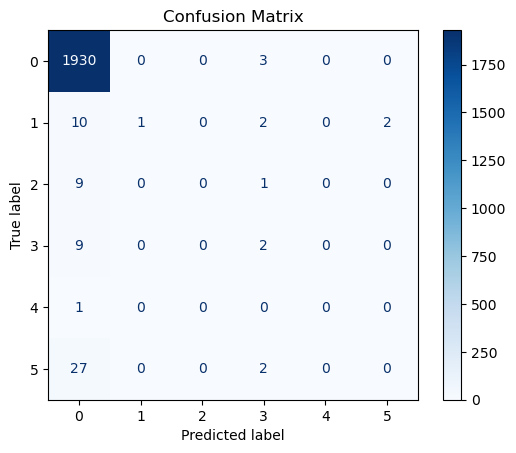

Evaluating Decision Tree...
Training Accuracy: 100.0%
Test Accuracy: 99.5%
Precision: 99.62%
Recall: 99.5%
F1 Score: 99.55%
--------------------------------------------------------
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1933
           1       0.92      0.80      0.86        15
           2       1.00      0.90      0.95        10
           3       0.77      0.91      0.83        11
           4       0.00      0.00      0.00         1
           5       0.93      0.97      0.95        29

    accuracy                           0.99      1999
   macro avg       0.77      0.76      0.76      1999
weighted avg       1.00      0.99      1.00      1999

--------------------------------------------------------


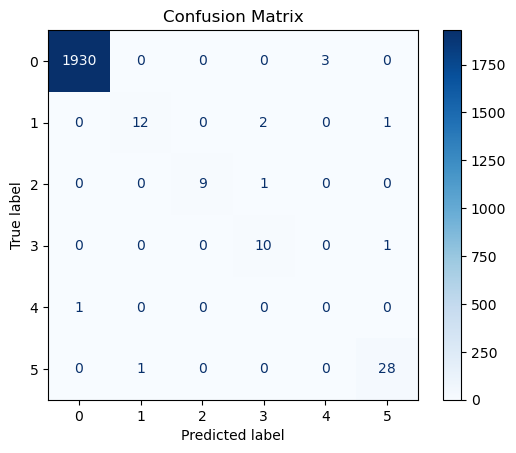

Evaluating Random Forest...
Training Accuracy: 100.0%
Test Accuracy: 99.75%
Precision: 99.71%
Recall: 99.75%
F1 Score: 99.72%
--------------------------------------------------------
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1933
           1       1.00      0.80      0.89        15
           2       1.00      1.00      1.00        10
           3       0.83      0.91      0.87        11
           4       0.00      0.00      0.00         1
           5       0.94      1.00      0.97        29

    accuracy                           1.00      1999
   macro avg       0.79      0.78      0.79      1999
weighted avg       1.00      1.00      1.00      1999

--------------------------------------------------------


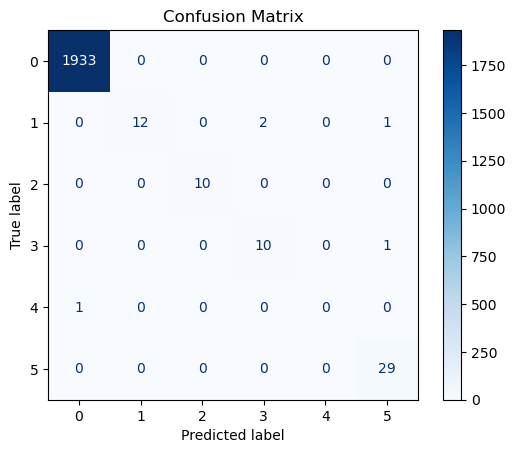

Evaluating Support Vector Machine...
Training Accuracy: 96.52%
Test Accuracy: 96.8%
Precision: 94.35%
Recall: 96.8%
F1 Score: 95.3%
--------------------------------------------------------
Classification Report: 
               precision    recall  f1-score   support

           0       0.97      1.00      0.98      1933
           1       1.00      0.13      0.24        15
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        11
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00        29

    accuracy                           0.97      1999
   macro avg       0.33      0.19      0.20      1999
weighted avg       0.94      0.97      0.95      1999

--------------------------------------------------------


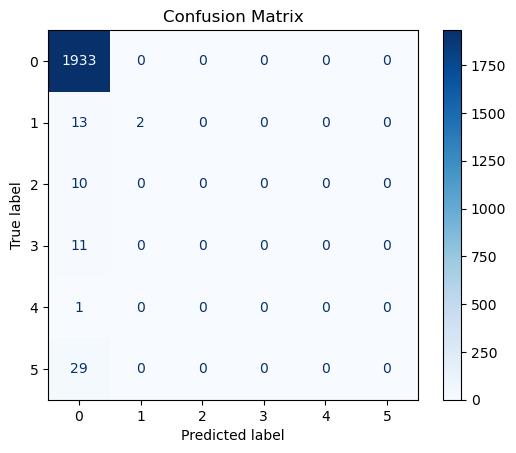

Evaluating Gradient Boosting...
Training Accuracy: 100.0%
Test Accuracy: 99.55%
Precision: 99.56%
Recall: 99.55%
F1 Score: 99.54%
--------------------------------------------------------
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1933
           1       0.92      0.73      0.81        15
           2       0.89      0.80      0.84        10
           3       0.77      0.91      0.83        11
           4       0.00      0.00      0.00         1
           5       0.94      1.00      0.97        29

    accuracy                           1.00      1999
   macro avg       0.75      0.74      0.74      1999
weighted avg       1.00      1.00      1.00      1999

--------------------------------------------------------


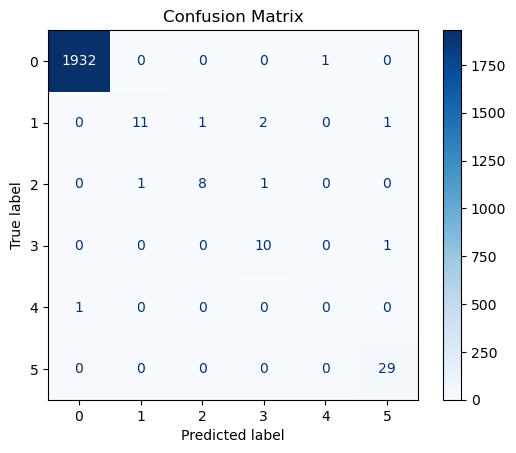

In [44]:
# Model Training and Evaluation

models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "Support Vector Machine": SVC(),
    "Gradient Boosting": GradientBoostingClassifier()
}

for name, model in models.items():
    print(f"Evaluating {name}...")
    evaluate_model(model, X_train, y_train, X_test, y_test)


Hyperparameter tuning for Logistic Regression...
Best parameters for Logistic Regression: {'C': 10}

Evaluating Logistic Regression with best parameters:
Training Accuracy: 0.966091091091091
Test Accuracy: 0.9664832416208105

Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1933
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00        10
           3       0.20      0.18      0.19        11
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00        29

    accuracy                           0.97      1999
   macro avg       0.20      0.20      0.20      1999
weighted avg       0.94      0.97      0.95      1999


Confusion Matrix (Test Data):

Hyperparameter tuning for Decision Tree...
Best parameters for Decision Tree: {'max_depth': 5, 'min_samples_split': 5}

Evaluating Decision Tree with best paramete

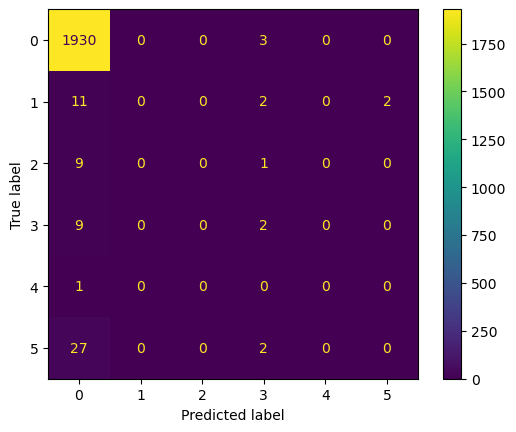

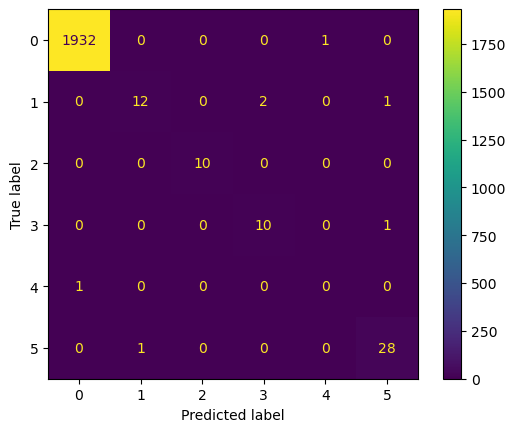

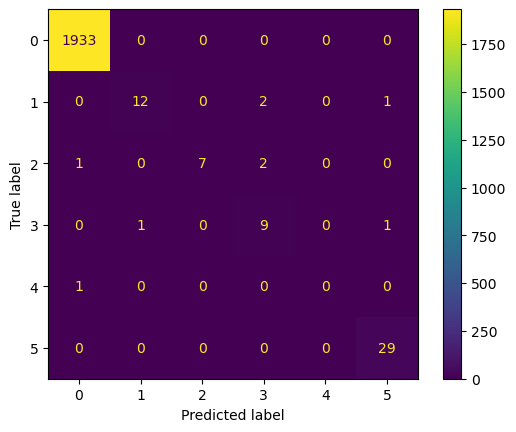

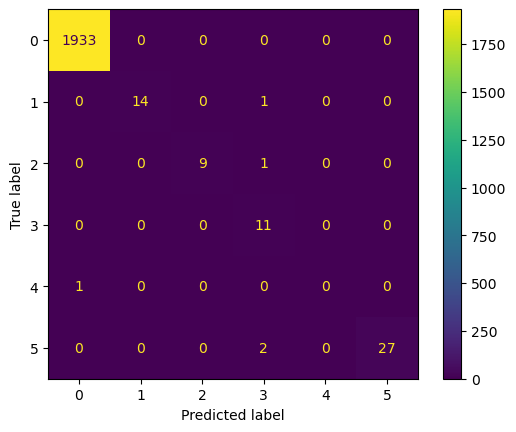

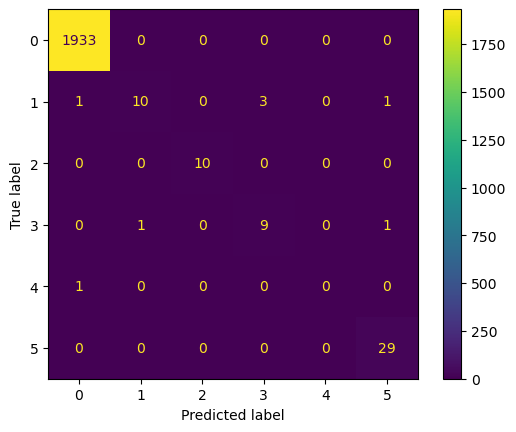

In [49]:
# Model Hyperparameter Tuning with GridSearchCV

# Hyperparameter grid
param_grid = {
    'Logistic Regression': {
        'C': [0.1, 1, 10]
    },
    'Decision Tree': {
        'max_depth': [5, 10, 15],
        'min_samples_split': [2, 5, 10]
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 10, 15]
    },
    'Support Vector Machine': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf']
    },
    'Gradient Boosting': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 1]
    }
}

def evaluate_model(model, X_train, y_train, X_test, y_test):
    # Predict on training set
    y_train_pred = model.predict(X_train)
    
    # Predict on test set
    y_test_pred = model.predict(X_test)
    
    # Evaluate the model
    print("Training Accuracy:", accuracy_score(y_train, y_train_pred))
    print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
    
    print("\nClassification Report (Test Data):")
    print(classification_report(y_test, y_test_pred))
    
    print("\nConfusion Matrix (Test Data):")
    cm = confusion_matrix(y_test, y_test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()

for name, model in models.items():
    print(f"\nHyperparameter tuning for {name}...")
    grid_search = GridSearchCV(model, param_grid[name], cv=5, scoring='accuracy', n_jobs=1)
    grid_search.fit(X_train, y_train)
    print(f"Best parameters for {name}: {grid_search.best_params_}")
    
    best_model = grid_search.best_estimator_
    
    # Evaluate the best model
    print(f"\nEvaluating {name} with best parameters:")
    evaluate_model(best_model, X_train, y_train, X_test, y_test)

### 6. Training and Saving

In [51]:
# Define and train models
logistic_regression_model = LogisticRegression()
logistic_regression_model.fit(X_train, y_train)

decision_tree_model = DecisionTreeClassifier()
decision_tree_model.fit(X_train, y_train)

random_forest_model = RandomForestClassifier(n_estimators=100)
random_forest_model.fit(X_train, y_train)

svm_model = SVC()
svm_model.fit(X_train, y_train)

gradient_boosting_model = GradientBoostingClassifier()
gradient_boosting_model.fit(X_train, y_train)

GradientBoostingClassifier()

In [53]:
print(f"Shape of X_train: {X_train.shape}")

Shape of X_train: (7992, 8)


In [52]:
import joblib

# Save models
joblib.dump(logistic_regression_model, 'logistic_regression_model.pkl')
joblib.dump(decision_tree_model, 'decision_tree_model.pkl')
joblib.dump(random_forest_model, 'random_forest_model.pkl')
joblib.dump(svm_model, 'svm_model.pkl')
joblib.dump(gradient_boosting_model, 'gradient_boosting_model.pkl')

# Save encoders and scalers if applicable
joblib.dump(encoder, 'encoder.pkl')
joblib.dump(scaler, 'scaler.pkl')


['scaler.pkl']